In [ ]:
default_params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'nrn_fr':nrn_fr,
    'pg_fr':pg_fr,
    'background_noise_fr':background_noise_fr,
    'seed':seed
}

scan_dict = {
    'M':[1,4,8,16,32],
    'N':[10,20,40,80,120],
    'D':[5,11,21,31,51,71,101,151,201],
    'T':[500,1000,1500,2000,5000],
    'nrn_fr':[5,10,15,20,25,35,50],
    'pg_fr':[4,5,8,10,15,20],
    'background_noise_fr':[0,2.5,5,7.5,10,12.5,15,20]
}

In [1]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate

In [31]:
filename = 'scan_stats.json'

In [1169]:
def generate_synthetic_data(params):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],    
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    K_dense = np.random.rand(N,D,M)*1000
    nrn_frs = np.zeros((M))
    for m in range(M):
        nrn_frs[m] = np.random.poisson(nrn_fr)
        K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
    K_sparse = np.where(K_dense)
    K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


    # dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
    # spare B: set of all times t and pg's b
    B_dense = np.random.rand(M,T)*1000
    pg_frs = np.zeros((M))
    for m in range(M):
        pg_frs[m] = np.random.poisson(pg_fr)
        B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
    B_sparse = np.where(B_dense)
    B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,0] = np.random.rand(N,T+D)*1000
    A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]

    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    
    stats = _get_stats(A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse)
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse, stats

def _get_stats(A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse):
    spikes_per_motif = np.sum(K_dense,axis=(0,1))
    motif_appearances = np.sum(B_dense,axis=1)
    total_spikes = np.sum(A_dense)
    snr = total_spikes - spikes_per_motif*motif_appearances
    snr[snr<0] = 0
    snr = (spikes_per_motif*motif_appearances)/snr
    return spikes_per_motif.tolist(), motif_appearances.tolist(), total_spikes.tolist(), snr.tolist()

In [ ]:
snr = total_spikes - spikes_per_motif*motif_appearnaces
snr[snr<] = 0
snr = (spike_per_motif*motif_appearances)/snr

In [1021]:
temp = [[K_sparse[0][K_sparse[2]==m].tolist().count(n) for n in range(A_dense.shape[0])] for m in range(1,1+K_dense.shape[2])]
[np.sum(k) for k in temp]

[3, 3, 2, 5, 8]

In [1082]:
A_dense.shape

(23, 1085)

In [1086]:
B_dense.shape

(4, 1000)

In [1106]:
K_dense.shape

(23, 85, 4)

In [1107]:
np.sum(K_dense,axis=(0,1)) # This tells me how many spikes per motif

array([8., 4., 9., 5.])

In [1105]:
np.sum(B_dense,axis=1)

array([4., 0., 2., 1.])

In [1097]:
np.sum(A_dense)

310.0

In [1103]:
j=5
params = {key: int(val) for key, val in zip(scan_dict.keys(), [scan_dict[k][j] for k in scan_dict.keys()])}
A_dense,A_sparse,B_dense,B_sparse,K_dense,K_sparse,stats = generate_synthetic_data(params)

In [1104]:
stats

array([0.11721612, 0.        , 0.06271777, 0.01666667])

In [1093]:
params

{'M': 4,
 'N': 23,
 'D': 85,
 'T': 1000,
 'nrn_fr': 4,
 'pg_fr': 1,
 'background_noise_fr': 10}

In [1053]:
[B_sparse[0].tolist().count(m) for m in range(1,1+B_dense.shape[0])]

[11, 16, 5, 15, 8]

In [1054]:
B_dense.shape

(5, 1000)

In [1055]:
stats[1]

[11, 16, 5, 15, 8]

In [1056]:
[B_sparse[0].tolist().count(m) for m in range(1,1+B_dense.shape[0])]

[11, 16, 5, 15, 8]

In [1167]:
def scan_raster(T_labels, N_labels, window_dim = None):
    '''
    T_labels an array of spiketimes
    N_labels corresponding array of neuron labels
    window_dim is the size of the window to cluster the spikes
    '''
    if window_dim == None:
        window_dim = 100
        
    T_labels = np.round(T_labels).astype(int)
    T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
    N=max(N_labels)+1

    print(f'{len(T_labels)} Windows')
    windows = np.zeros((len(T_labels)),dtype='object')
    for i,window_time in enumerate(T_labels):
        condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
        window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
        window =  {tuple(row) for row in  window}
        windows[i] = window
        print(f'Windowing... {round(100*i/len(T_labels))}%',end='\r')
        
   
    max_iter = 50
    x = np.arange(0,100)
    fun = lambda x,c : x**(1+c)/10**(2*c+1)
    list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))

    opt_cutoff = 0
    max_seq_rep = 0
    sim_mats = _get_sim_mats(windows, T_labels, N_labels)
    
    
    print("Clustering...",end="\r")

    for i, cutoff in enumerate(list_cutoffs): 
        clusters = _cluster_windows(cutoff, N_labels, sim_mats)
        cluster_sq, _sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

        if len(sublist_keys_filt) != 0:
            max_ = np.max([len(k) for k in sublist_keys_filt])
            if max_seq_rep < max_:
                max_seq_rep = max_
                opt_cutoff=cutoff

        print(f'progress - {100*i/max_iter}% | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

    clusters = _cluster_windows(opt_cutoff, N_labels, sim_mats)
    cluster_sq, sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)
    

    ''' to get the timings'''

    # Sort y according to x
    sorted_indices = np.argsort(T_labels)
    sorted_x = T_labels[sorted_indices]
    
    print("Re-Clustering...",end="\r")

    all_times = []
    all_labels = []
    for key in sublist_keys_filt:
        pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
        for i,k in enumerate(cluster_sq[str(key)]):
            pattern_repetition_labels[i][clusters==k] = 1
            pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
        pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
        all_labels.append(pattern_repetition_labels)

        sorted_y = pattern_repetition_labels[sorted_indices]
        pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
        all_times.append(pattern_times)
        
    print("Extracting templates...",end="\r")

    pattern_template = []
    patterns = []
    for i in range(len(all_times)):
        pattern = []
        pattern_template.append([])
        for time in all_times[i]:
            condition = (T_labels > time-window_dim*2) & (T_labels < time + window_dim*2)
            pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
            pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
            patterns.append(pattern)
        print(f"Extracting templates... {round(100*i/len(all_times))}%",end="\r")
    
    print(f"{len(pattern_template)} patterns found...")

    for i,pattern in enumerate(pattern_template):
        counts = [pattern.count(k) for k in pattern]
        pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
        pattern_template[i][:,0] -= min(pattern_template[i][:,0])
        pattern_template[i] = np.unique(pattern_template[i],axis=0)
    
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, sublist_keys_filt, None
    
    win_size = (K_dense.shape[0],1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1

    return pattern_template, sublist_keys_filt, pattern_img

def _get_sim_mats(windows, T_labels, N_labels):
    sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        windows_n = windows[idc]
        if len(windows_n) > 1:
            x = np.zeros((len(windows_n),len(windows_n)))
            for i in range(windows_n.shape[0]):
                for j in range(windows_n.shape[0]):
                    common_rows = windows_n[i].intersection(windows_n[j])
                    num_identical_rows = len(common_rows)
                    x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
            np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
            sim_mats[n] = x-1 
        print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")
    return sim_mats

def _cluster_windows(cutoff, N_labels, sim_mats):
    clusters = np.zeros_like(N_labels)
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        if (type(sim_mats[n]) == np.ndarray) and (not np.all(sim_mats[n] == 0)):
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(sim_mats[n], method='complete'), cutoff, criterion='distance')
    return clusters

def _check_seq(clusters, T_labels, N_labels):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_keys_filt = [list(k) for k in sublist_keys_filt]
    
    return cluster_sq, sq_counts, sublist_keys_filt


In [34]:
from scipy.signal import correlate
def get_acc(ground_truths,detected_patterns):
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((ground_truths.shape[2], detected_patterns.shape[2]))
    SM_acc = np.zeros((ground_truths.shape[2]))
    
    if len(detected_patterns) == 0:
        return SM_acc, cross_corr_matrix
    
    for ground_truths_idx in range(ground_truths.shape[2]):
        for detected_patterns_idx in range(detected_patterns.shape[2]):
            cross_corr = np.zeros((ground_truths.shape[1]+detected_patterns.shape[1]-1))
            for n in range(ground_truths.shape[0]):
                cross_corr += correlate(ground_truths[n, :, ground_truths_idx], detected_patterns[n, :, detected_patterns_idx], mode='full')
            max_corr = np.max(cross_corr) / max(np.sum(ground_truths[...,ground_truths_idx]),np.sum(detected_patterns[...,detected_patterns_idx]))
            cross_corr_matrix[ground_truths_idx, detected_patterns_idx] = max_corr
#     print(cross_corr_matrix)
#     print( np.sum(ground_truths[...,ground_truths_idx]))
    SM_acc = np.max(cross_corr_matrix,axis=1)
    return SM_acc, cross_corr_matrix

In [ ]:
default_params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'nrn_fr':nrn_fr,
    'pg_fr':pg_fr,
    'background_noise_fr':background_noise_fr,
    'seed':seed
}
scan_dict = {
    'M':[1,2,4,8,16,32,64,128],
    'N':[5,10,15,20,40,80,160,200],
    'D':[5,11,21,31,51,71,101,151,201],
    'T':[500,1000,1500,2000,5000],
    'nrn_fr':[5,10,15,20,25,35,50],
    'pg_fr':[4,5,8,10,15,20],
    'background_noise_fr':[0,2.5,5,7.5,10,12.5,15,20]
}

In [782]:
def gen_dist(l,mu, sigma,max_,min_):
    x = np.ones(l)*max_
    x = np.round(np.random.lognormal(mu,sigma, l))
    while (bool(np.any(x>=max_)) or bool(np.any(x<=min_))):
        x[x>=max_] = np.random.lognormal(mu,sigma,len(x[x>=max_]))
        x[x<=min_] = np.random.lognormal(mu,sigma,len(x[x<=min_]))
        x = np.round(x)
    return x

In [670]:
def gen_N(l,mu=2, sigma=1,max_=200):
    x = np.round(np.random.uniform(0,max_,l))
    return x

False


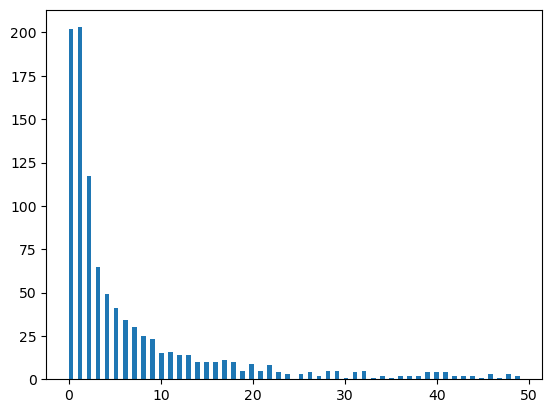

In [817]:
plt.figure()
plt.hist(gen_dist(1000,1,2,50,-1).astype('int') ,bins=100)
plt.show()

In [737]:
num_samples = 1000  # Adjust this based on your computational resources

scan_dict = {
    'M':gen_dist(num_samples,2,2,100,0).astype('int'),
    'N':gen_dist(num_samples,2,1.5,100,9).astype('int'),
    'D':gen_dist(num_samples,5,1,200,9).astype('int'),
    'T':(np.ones(num_samples)*1000).astype('int'),
    'nrn_fr':gen_dist(1000,2,2,50,3).astype('int'),
    'pg_fr':gen_dist(1000,1,5,50,0).astype('int'),
    'background_noise_fr':gen_dist(1000,1,2,50,-1).astype('int')
}


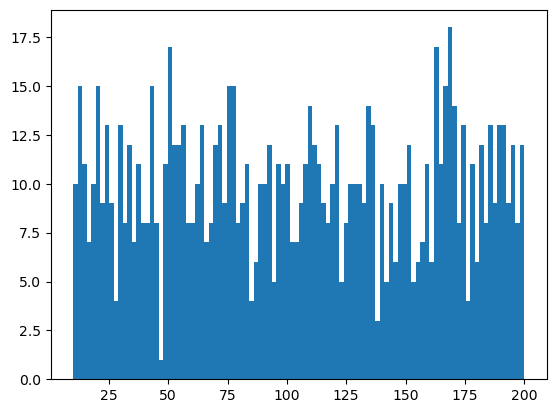

In [687]:
plt.figure()
plt.hist(scan_dict['D'],bins=100)
plt.show()

In [659]:
[[scan_dict[k][i] for k in scan_dict.keys()] for i in range(10)]

[[4, 174, 143, 1000, 29.8, 13.4, 2.5],
 [18, 20, 187, 1000, 41.0, 18.4, 3.7],
 [3, 10, 81, 1000, 30.6, 8.4, 2.3],
 [12, 164, 151, 1000, 22.7, 9.8, 7.2],
 [6, 44, 17, 1000, 32.0, 12.1, 9.3],
 [15, 187, 127, 1000, 9.6, 17.1, 8.2],
 [226, 37, 199, 1000, 13.5, 17.7, 1.3],
 [5, 141, 179, 1000, 16.5, 4.5, 0.5],
 [13, 33, 188, 1000, 40.1, 17.8, 5.0],
 [6, 196, 108, 1000, 27.7, 9.2, 0.2]]

In [1170]:
import time
# def main():
    # Define the number of random samples you want to take
num_samples = 50  # Adjust this based on your computational resources

scan_dict = {
    'M':gen_dist(num_samples,2,2,100,0).astype('int'),
    'N':gen_dist(num_samples,2,1.5,100,9).astype('int'),
    'D':gen_dist(num_samples,5,1,200,9).astype('int'),
    'T':(np.ones(num_samples)*1000).astype('int'),
    'nrn_fr':gen_dist(1000,2,2,50,3).astype('int'),
    'pg_fr':gen_dist(1000,1,5,50,0).astype('int'),
    'background_noise_fr':gen_dist(1000,1,2,50,-1).astype('int')
}

# List to hold the results
results = []

# Iterate through parameter combinations
for idx in tqdm(range(num_samples)):
    seed=0
    performance_result = (np.nan, np.nan, np.nan, [np.nan])
    SM_acc = np.array([])

    if os.path.isfile(filename):
        with open(filename, 'r') as results_file:
            results = json.load(results_file)

    np.random.seed(seed)
    params = {key: int(val) for key, val in zip(scan_dict.keys(), [scan_dict[k][idx] for k in scan_dict.keys()])}
#             params = {'M': 4, 'N': 60, 'D': 10, 'T': 1000, 'nrn_fr': 15, 'pg_fr': 4, 'background_noise_fr': 10}

    # Run your program here to generate performance results
    print("Params:", params)
    print("Generating raster plot...")
    _, A_sparse, _, B_sparse, K_dense, K_sparse, stats = generate_synthetic_data(params)
    tries = 0
    while len(A_sparse[0]) > 3000 or len(A_sparse[0])==0:
        print(np.sum(stats[0]), len(A_sparse[0]))
        _, A_sparse, _, B_sparse, K_dense, K_sparse, stats = generate_synthetic_data(params)
        if tries == 10:
            break
        tries+=1
        
    start = time.time()
    if tries != 10:
        pattern_template, sublist_keys_filt, pattern_img = scan_raster(A_sparse[1],A_sparse[0],window_dim=params['D'])
    
        if pattern_img is not None:
            pattern_img = np.transpose(pattern_img,axes=[1,2,0])
            SM_acc, _ = get_acc(K_dense, pattern_img)
            performance_result = (np.sum(SM_acc>0.8)/len(SM_acc), np.mean(SM_acc[SM_acc>0.8]), np.mean(SM_acc), list(SM_acc))
        else:
            performance_result = (None, None, None, None)
    end = time.time()

    # Create a dictionary to store the result
    print(stats[1])
    result = {
        'spikes_per_motif':stats[0],
        'motif_appearances':stats[1],
        'total_spikes':stats[2],
        'snr':stats[3],
        **params,  # Unpack the parameters as separate columns
        'SM_acc':SM_acc.tolist(),
        'pct good SM detected':performance_result[0],
        'good SM quality':performance_result[1],
        'all SM quality':performance_result[2],
        'SM_acc':performance_result[3],
        'time':round(end-start)
    }

    print(performance_result, np.sum(stats[0]))

    # Append the result to the list
    results.append(result)
    # Write the entire list of results to a JSON file
    with open(filename, 'w') as results_file:
        json.dump(results, results_file, indent=4)
# results = main()


False
False
False
False
False
False


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Params: {'M': 1, 'N': 40, 'D': 161, 'T': 1000, 'nrn_fr': 17, 'pg_fr': 13, 'background_noise_fr': 0}
Generating raster plot...
1018 Windows


C:\Users\miles\AppData\Local\Temp\ipykernel_13416\3488205279.py:58: RuntimeWarning: divide by zero encountered in divide
  snr = (spikes_per_motif*motif_appearances)/snr


3 patterns found...s... 67% 10.01 | opt_cutoff - 2.78 | most_detections - 22tections - 22


  2%|█▋                                                                                 | 1/50 [00:16<13:35, 16.65s/it]

[12.0]
(1.0, 1.0, 1.0, [1.0]) 86.0
Params: {'M': 34, 'N': 36, 'D': 28, 'T': 1000, 'nrn_fr': 11, 'pg_fr': 20, 'background_noise_fr': 3}
Generating raster plot...
409.0 8232
393.0 7653
378.0 7354
378.0 7772
386.0 7496
386.0 7127
355.0 6945


  4%|███▎                                                                               | 2/50 [00:16<05:37,  7.04s/it]

380.0 6787
380.0 7545
309.0 6177
389.0 7725
[13.0, 25.0, 21.0, 12.0, 39.0, 9.0, 19.0, 29.0, 12.0, 13.0, 15.0, 20.0, 21.0, 21.0, 26.0, 29.0, 31.0, 20.0, 17.0, 13.0, 20.0, 23.0, 25.0, 22.0, 16.0, 14.0, 16.0, 18.0, 14.0, 18.0, 20.0, 13.0, 7.0, 23.0]
(nan, nan, nan, [nan]) 353.0
Params: {'M': 4, 'N': 19, 'D': 81, 'T': 1000, 'nrn_fr': 8, 'pg_fr': 1, 'background_noise_fr': 1}
Generating raster plot...
97 Windows


C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|████▉                                                                              | 3/50 [00:17<03:04,  3.93s/it]

1 patterns found...
[1.0, 3.0, 1.0, 2.0]
(0.0, nan, 0.09126984126984126, [0.14285714285714285, 0.2222222222222222, 0.0, 0.0]) 53.0
Params: {'M': 1, 'N': 23, 'D': 54, 'T': 1000, 'nrn_fr': 9, 'pg_fr': 3, 'background_noise_fr': 1}
Generating raster plot...
77 Windows


  8%|██████▋                                                                            | 4/50 [00:17<01:53,  2.46s/it]

2 patterns found...s... 50% 10.01 | opt_cutoff - 1.09 | most_detections - 2etections - 2
[3.0]
(1.0, 1.0, 1.0, [1.0]) 17.0
Params: {'M': 25, 'N': 49, 'D': 54, 'T': 1000, 'nrn_fr': 19, 'pg_fr': 1, 'background_noise_fr': 1}
Generating raster plot...
630 Windows


 10%|████████▎                                                                          | 5/50 [00:18<01:28,  1.97s/it]

1 patterns found...
[2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
(0.0, nan, 0.02772664798527007, [0.03125, 0.02857142857142857, 0.034482758620689655, 0.017543859649122806, 0.0273972602739726, 0.057692307692307696, 0.023809523809523808, 0.02040816326530612, 0.0425531914893617, 0.03225806451612903, 0.024390243902439025, 0.030303030303030304, 0.015151515151515152, 0.023809523809523808, 0.06818181818181818, 0.016129032258064516, 0.0196078431372549, 0.03571428571428571, 0.017543859649122806, 0.030303030303030304, 0.02857142857142857, 0.017241379310344827, 0.018518518518518517, 0.017241379310344827, 0.014492753623188406]) 1206.0
Params: {'M': 11, 'N': 19, 'D': 46, 'T': 1000, 'nrn_fr': 6, 'pg_fr': 1, 'background_noise_fr': 3}
Generating raster plot...
94 Windows


 12%|█████████▉                                                                         | 6/50 [00:18<01:00,  1.38s/it]

0 patterns found...s...ff - 10.01 | opt_cutoff - 0 | most_detections - 0etections - 00
FAIL
[3.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]
(None, None, None, None) 83.0
Params: {'M': 4, 'N': 27, 'D': 36, 'T': 1000, 'nrn_fr': 37, 'pg_fr': 2, 'background_noise_fr': 4}
Generating raster plot...
429 Windows


 14%|███████████▌                                                                       | 7/50 [00:19<00:49,  1.15s/it]

2 patterns found...s... 50% 10.01 | opt_cutoff - 1.37 | most_detections - 4etections - 4
[2.0, 0.0, 5.0, 0.0]
(0.25, 1.0, 0.3045454545454545, [0.07272727272727272, 0.09090909090909091, 1.0, 0.05454545454545454]) 139.0
Params: {'M': 2, 'N': 35, 'D': 142, 'T': 1000, 'nrn_fr': 22, 'pg_fr': 1, 'background_noise_fr': 0}
Generating raster plot...
169 Windows


 16%|█████████████▎                                                                     | 8/50 [00:19<00:38,  1.08it/s]

3 patterns found...s... 67% 10.01 | opt_cutoff - 0.04 | most_detections - 1etections - 1
[1.0, 0.0]
(0.0, nan, 0.017350315916156857, [0.01775147928994083, 0.01694915254237288]) 287.0
Params: {'M': 85, 'N': 21, 'D': 132, 'T': 1000, 'nrn_fr': 7, 'pg_fr': 1, 'background_noise_fr': 1}
Generating raster plot...
1758 Windows
8 patterns found...s... 88% 10.01 | opt_cutoff - 0.2 | most_detections - 1etections - 11


 18%|██████████████▉                                                                    | 9/50 [00:25<01:43,  2.52s/it]

[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 3.0, 4.0, 1.0, 1.0, 6.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 5.0, 0.0, 0.0, 1.0, 2.0, 1.0, 3.0, 2.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 1.0, 0.0, 5.0, 0.0, 2.0, 1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0]
(0.0, nan, 0.057841651832626274, [0.05128205128205128, 0.08, 0.05128205128205128, 0.05128205128205128, 0.07692307692307693, 0.05128205128205128, 0.07692307692307693, 0.05128205128205128, 0.02857142857142857, 0.05128205128205128, 0.05128205128205128, 0.06, 0.05128205128205128, 0.05128205128205128, 0.057692307692307696, 0.12, 0.06, 0.07692307692307693, 0.09615384615384616, 0.05128205128205128, 0.04, 0.07692307692307693, 0.04285714285714286, 0.04, 0.06, 0.06, 0.09615384615384616, 0.038461538461538464, 0.07142857142857142, 0.02857142857142857, 0.06, 0.05128205128205128, 0

 22%|██████████████████                                                                | 11/50 [00:26<00:54,  1.40s/it]

2 patterns found...s... 50% 10.01 | opt_cutoff - 1.68 | most_detections - 16tections - 16
[14.0, 10.0, 22.0, 9.0, 6.0, 23.0, 19.0, 5.0, 10.0, 4.0, 11.0, 11.0, 11.0, 3.0, 17.0, 19.0, 17.0, 16.0, 3.0, 13.0, 7.0, 10.0, 13.0, 20.0, 10.0, 9.0, 9.0, 9.0]
(0.03571428571428571, 1.0, 0.13392857142857142, [0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 1.0, 0.0, 0.25, 0.0, 0.25, 0.25, 0.25, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25]) 33.0
Params: {'M': 23, 'N': 16, 'D': 178, 'T': 1000, 'nrn_fr': 33, 'pg_fr': 3, 'background_noise_fr': 18}
Generating raster plot...
2247.0 7040
2213.0 7199
2274.0 7114
2203.0 7524
2073.0 7007
2200.0 9069
2024.0 6654
2191.0 4938
2235.0 5774
2085.0 5690
2150.0 6957
[0.0, 2.0, 4.0, 9.0, 7.0, 3.0, 2.0, 10.0, 1.0, 0.0, 4.0, 1.0, 0.0, 2.0, 4.0, 2.0, 2.0, 0.0, 20.0, 0.0, 2.0, 3.0, 1.0]
(nan, nan, nan, [nan]) 2164.0
Params: {'M': 1, 'N': 35, 'D': 186, 'T': 1000, 'nrn_fr': 20, 'pg_fr': 1, 'background_noise_fr': 2}
Generating raster plot...
80 Windows


 24%|███████████████████▋                                                              | 12/50 [00:26<00:39,  1.04s/it]

0 patterns found...s...ff - 10.01 | opt_cutoff - 0 | most_detections - 0
FAIL
[0.0]
(None, None, None, None) 112.0
Params: {'M': 20, 'N': 11, 'D': 195, 'T': 1000, 'nrn_fr': 5, 'pg_fr': 5, 'background_noise_fr': 9}
Generating raster plot...
1355 Windows
21 patterns found...... 95% 10.01 | opt_cutoff - 0.34 | most_detections - 2etections - 22


 28%|██████████████████████▉                                                           | 14/50 [00:35<01:22,  2.28s/it]

[3.0, 9.0, 9.0, 2.0, 6.0, 8.0, 10.0, 3.0, 6.0, 3.0, 6.0, 2.0, 7.0, 3.0, 10.0, 2.0, 2.0, 6.0, 5.0, 7.0]
(0.0, nan, 0.08932347410164902, [0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.0896551724137931, 0.13821138211382114, 0.08333333333333333, 0.0625, 0.0625, 0.08333333333333333, 0.13821138211382114, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.13513513513513514, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.07692307692307693]) 241.0
Params: {'M': 3, 'N': 17, 'D': 95, 'T': 1000, 'nrn_fr': 9, 'pg_fr': 1, 'background_noise_fr': 1}
Generating raster plot...
32 Windows
0 patterns found...
FAIL
[0.0, 1.0, 0.0]
(None, None, None, None) 54.0
Params: {'M': 15, 'N': 32, 'D': 72, 'T': 1000, 'nrn_fr': 25, 'pg_fr': 13, 'background_noise_fr': 4}
Generating raster plot...
974.0 12525
870.0 12324
829.0 12194
862.0 11598
758.0 8487
888.0 11380


 30%|████████████████████████▌                                                         | 15/50 [00:35<00:57,  1.64s/it]

841.0 10852
907.0 10145
901.0 10387
846.0 10936
931.0 14245
[16.0, 13.0, 9.0, 8.0, 14.0, 12.0, 6.0, 5.0, 15.0, 13.0, 20.0, 14.0, 2.0, 11.0, 5.0]
(nan, nan, nan, [nan]) 939.0
Params: {'M': 49, 'N': 14, 'D': 47, 'T': 1000, 'nrn_fr': 4, 'pg_fr': 19, 'background_noise_fr': 2}
Generating raster plot...
166.0 3139
2315 Windows
2 patterns found...s... 50% 10.01 | opt_cutoff - 0.83 | most_detections - 2etections - 21_detections - 1


 34%|███████████████████████████▉                                                      | 17/50 [00:45<01:33,  2.83s/it]

[18.0, 13.0, 14.0, 20.0, 21.0, 22.0, 8.0, 20.0, 28.0, 11.0, 14.0, 16.0, 16.0, 28.0, 20.0, 32.0, 19.0, 23.0, 18.0, 21.0, 14.0, 14.0, 14.0, 15.0, 16.0, 15.0, 4.0, 23.0, 22.0, 23.0, 23.0, 31.0, 25.0, 17.0, 25.0, 16.0, 17.0, 23.0, 23.0, 15.0, 33.0, 20.0, 18.0, 17.0, 12.0, 14.0, 15.0, 12.0, 16.0]
(0.0, nan, 0.10146450606820802, [0.14285714285714285, 0.0, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.023255813953488372, 0.0, 0.14285714285714285, 0.09302325581395349, 0.0, 0.023255813953488372, 0.14285714285714285, 0.25, 0.0, 0.14285714285714285, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.25, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.0, 0.023255813953488372, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.0, 0.14285714285714285, 

 36%|█████████████████████████████▌                                                    | 18/50 [00:51<02:05,  3.93s/it]

[16.0, 10.0, 10.0, 9.0, 8.0]
(0.6, 0.956989247311828, 0.6253593940357011, [1.0, 0.10344827586206896, 0.1523809523809524, 1.0, 0.8709677419354839]) 115.0
Params: {'M': 21, 'N': 19, 'D': 52, 'T': 1000, 'nrn_fr': 6, 'pg_fr': 1, 'background_noise_fr': 0}
Generating raster plot...
169 Windows


 38%|███████████████████████████████▏                                                  | 19/50 [00:51<01:28,  2.85s/it]

6 patterns found...
[0.0, 0.0, 3.0, 5.0, 4.0, 5.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
(0.14285714285714285, 1.0, 0.25784083641226496, [0.1, 0.0, 0.125, 1.0, 1.0, 1.0, 0.125, 0.14285714285714285, 0.2, 0.14285714285714285, 0.2, 0.07692307692307693, 0.2, 0.1111111111111111, 0.0, 0.2, 0.09090909090909091, 0.2, 0.14285714285714285, 0.07142857142857142, 0.2857142857142857]) 147.0
Params: {'M': 5, 'N': 67, 'D': 35, 'T': 1000, 'nrn_fr': 30, 'pg_fr': 24, 'background_noise_fr': 23}
Generating raster plot...
367.0 11113
285.0 8257
315.0 7924
286.0 7966
365.0 10290
338.0 9371
350.0 9599
362.0 9475
363.0 10479
316.0 8884
338.0 10949


 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:00,  2.03s/it]

[19.0, 14.0, 25.0, 20.0, 21.0]
(nan, nan, nan, [nan]) 393.0
Params: {'M': 4, 'N': 12, 'D': 166, 'T': 1000, 'nrn_fr': 38, 'pg_fr': 45, 'background_noise_fr': 5}
Generating raster plot...
291.0 12330
287.0 11510
285.0 9244
315.0 11966
288.0 10557
260.0 8095
328.0 10458
261.0 8353
314.0 13250
266.0 10405
318.0 11878
[61.0, 44.0, 28.0, 48.0]
(nan, nan, nan, [nan]) 341.0
Params: {'M': 3, 'N': 26, 'D': 92, 'T': 1000, 'nrn_fr': 44, 'pg_fr': 1, 'background_noise_fr': 1}
Generating raster plot...
746 Windows
18 patterns found...... 94% 10.01 | opt_cutoff - 0.61 | most_detections - 5etections - 5t_detections - 1


 44%|████████████████████████████████████                                              | 22/50 [00:54<00:47,  1.68s/it]

[7.0, 1.0, 0.0]
(0.3333333333333333, 1.0, 0.39304812834224595, [1.0, 0.08823529411764706, 0.09090909090909091]) 354.0
Params: {'M': 31, 'N': 25, 'D': 112, 'T': 1000, 'nrn_fr': 38, 'pg_fr': 30, 'background_noise_fr': 1}
Generating raster plot...
3211.0 86474
3269.0 88370
3216.0 98616
3270.0 92369
3238.0 82416
3156.0 86990
3507.0 92383
3267.0 93871
3010.0 77944
3310.0 92140


 46%|█████████████████████████████████████▋                                            | 23/50 [00:55<00:37,  1.39s/it]

3319.0 97052
[18.0, 31.0, 22.0, 40.0, 24.0, 33.0, 28.0, 26.0, 29.0, 29.0, 28.0, 24.0, 40.0, 29.0, 26.0, 51.0, 41.0, 27.0, 31.0, 25.0, 43.0, 38.0, 31.0, 25.0, 32.0, 23.0, 42.0, 32.0, 27.0, 23.0, 45.0]
(nan, nan, nan, [nan]) 3122.0
Params: {'M': 15, 'N': 13, 'D': 23, 'T': 1000, 'nrn_fr': 5, 'pg_fr': 17, 'background_noise_fr': 15}
Generating raster plot...
606 Windows
1 patterns found...s... 0%- 10.01 | opt_cutoff - 0.67 | most_detections - 11tections - 11
[18.0, 14.0, 17.0, 26.0, 26.0, 18.0, 15.0, 13.0, 14.0, 13.0, 16.0, 23.0, 7.0, 21.0, 36.0]
(0.06666666666666667, 1.0, 0.10666666666666666, [0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.0]) 23.0


 50%|█████████████████████████████████████████                                         | 25/50 [00:55<00:23,  1.06it/s]

Params: {'M': 24, 'N': 17, 'D': 34, 'T': 1000, 'nrn_fr': 20, 'pg_fr': 22, 'background_noise_fr': 0}
Generating raster plot...
269.0 6242
252.0 5446
285.0 6213
270.0 5708
264.0 6066
293.0 6034
266.0 5903
239.0 4696
291.0 6045
274.0 5711
253.0 5292
[27.0, 29.0, 17.0, 21.0, 17.0, 20.0, 21.0, 12.0, 22.0, 29.0, 20.0, 16.0, 22.0, 10.0, 15.0, 20.0, 11.0, 15.0, 32.0, 21.0, 15.0, 17.0, 19.0, 22.0]
(nan, nan, nan, [nan]) 313.0
Params: {'M': 60, 'N': 15, 'D': 136, 'T': 1000, 'nrn_fr': 4, 'pg_fr': 20, 'background_noise_fr': 16}
Generating raster plot...
459.0 9329
533.0 11024
522.0 10680
501.0 9772
495.0 9740
415.0 8471
501.0 10620


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:56<00:19,  1.21it/s]

451.0 9560
490.0 9771
524.0 11160
486.0 10822
[24.0, 19.0, 23.0, 28.0, 25.0, 17.0, 26.0, 20.0, 28.0, 19.0, 16.0, 19.0, 7.0, 19.0, 18.0, 20.0, 19.0, 36.0, 21.0, 20.0, 11.0, 21.0, 17.0, 18.0, 22.0, 18.0, 19.0, 16.0, 26.0, 23.0, 14.0, 12.0, 25.0, 25.0, 20.0, 20.0, 11.0, 20.0, 14.0, 24.0, 22.0, 13.0, 30.0, 13.0, 21.0, 31.0, 12.0, 18.0, 10.0, 22.0, 20.0, 16.0, 11.0, 26.0, 10.0, 20.0, 22.0, 28.0, 16.0, 15.0]
(nan, nan, nan, [nan]) 447.0
Params: {'M': 2, 'N': 44, 'D': 62, 'T': 1000, 'nrn_fr': 4, 'pg_fr': 1, 'background_noise_fr': 2}
Generating raster plot...
101 Windows


 54%|████████████████████████████████████████████▎                                     | 27/50 [00:56<00:16,  1.44it/s]

0 patterns found...s...ff - 10.01 | opt_cutoff - 0 | most_detections - 0etections - 0
FAIL
[0.0, 1.0]
(None, None, None, None) 17.0
Params: {'M': 6, 'N': 13, 'D': 59, 'T': 1000, 'nrn_fr': 28, 'pg_fr': 1, 'background_noise_fr': 16}
Generating raster plot...
446 Windows


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:57<00:15,  1.45it/s]

4 patterns found...s... 75% 10.01 | opt_cutoff - 0.83 | most_detections - 7etections - 7
[1.0, 0.0, 1.0, 8.0, 1.0, 0.0]
(0.16666666666666666, 1.0, 0.2586943707633363, [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 1.0, 0.10344827586206896, 0.11538461538461539]) 132.0
Params: {'M': 8, 'N': 11, 'D': 77, 'T': 1000, 'nrn_fr': 7, 'pg_fr': 5, 'background_noise_fr': 0}
Generating raster plot...
410 Windows
4 patterns found...s... 75% 10.01 | opt_cutoff - 0.72 | most_detections - 15tections - 15


 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:58<00:17,  1.22it/s]

[16.0, 8.0, 1.0, 6.0, 8.0, 9.0, 9.0, 7.0]
(0.25, 1.0, 0.3610368389780155, [1.0, 0.1111111111111111, 0.09090909090909091, 0.35294117647058826, 0.1111111111111111, 1.0, 0.1111111111111111, 0.1111111111111111]) 53.0
Params: {'M': 12, 'N': 33, 'D': 35, 'T': 1000, 'nrn_fr': 5, 'pg_fr': 1, 'background_noise_fr': 0}
Generating raster plot...
152 Windows


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:59<00:14,  1.36it/s]

4 patterns found...
[6.0, 0.0, 0.0, 4.0, 0.0, 2.0, 0.0, 2.0, 6.0, 1.0, 5.0, 0.0]
(0.3333333333333333, 1.0, 0.40625, [1.0, 0.125, 0.125, 1.0, 0.125, 1.0, 0.0, 0.25, 0.0, 0.125, 1.0, 0.125]) 61.0
Params: {'M': 4, 'N': 40, 'D': 54, 'T': 1000, 'nrn_fr': 6, 'pg_fr': 2, 'background_noise_fr': 0}
Generating raster plot...
58 Windows


 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:59<00:11,  1.71it/s]

1 patterns found...s... 0%- 10.01 | opt_cutoff - 1.68 | most_detections - 2etections - 2
[0.0, 3.0, 1.0, 1.0]
(0.25, 1.0, 0.3012987012987013, [0.047619047619047616, 1.0, 0.09090909090909091, 0.06666666666666667]) 57.0
Params: {'M': 29, 'N': 12, 'D': 35, 'T': 1000, 'nrn_fr': 18, 'pg_fr': 8, 'background_noise_fr': 0}
Generating raster plot...
1770 Windows
17 patterns found...... 94% 10.01 | opt_cutoff - 0.61 | most_detections - 2etections - 2


 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:04<00:33,  1.87s/it]

[16.0, 4.0, 11.0, 5.0, 3.0, 8.0, 11.0, 8.0, 10.0, 8.0, 12.0, 8.0, 7.0, 13.0, 15.0, 13.0, 10.0, 11.0, 6.0, 9.0, 8.0, 7.0, 11.0, 9.0, 3.0, 14.0, 6.0, 8.0, 6.0]
(0.0, nan, 0.1469882267666887, [0.15384615384615385, 0.11764705882352941, 0.22580645161290322, 0.09523809523809523, 0.14285714285714285, 0.07142857142857142, 0.6428571428571429, 0.14285714285714285, 0.07142857142857142, 0.08695652173913043, 0.14285714285714285, 0.07142857142857142, 0.26666666666666666, 0.07142857142857142, 0.08695652173913043, 0.10526315789473684, 0.08695652173913043, 0.14285714285714285, 0.15555555555555556, 0.08695652173913043, 0.08333333333333333, 0.0967741935483871, 0.07142857142857142, 0.4, 0.13043478260869565, 0.1388888888888889, 0.14285714285714285, 0.08823529411764706, 0.14285714285714285]) 224.0
Params: {'M': 2, 'N': 56, 'D': 125, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 3, 'background_noise_fr': 1}
Generating raster plot...
157 Windows


 66%|██████████████████████████████████████████████████████                            | 33/50 [01:04<00:24,  1.44s/it]

3 patterns found...s... 67% 10.01 | opt_cutoff - 0.61 | most_detections - 3etections - 32_detections - 2
[0.0, 4.0]
(0.5, 1.0, 0.5142857142857142, [0.02857142857142857, 1.0]) 95.0
Params: {'M': 1, 'N': 11, 'D': 102, 'T': 1000, 'nrn_fr': 13, 'pg_fr': 42, 'background_noise_fr': 1}
Generating raster plot...
1605 Windows
3 patterns found...s... 67% 10.01 | opt_cutoff - 1.68 | most_detections - 55tections - 55


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:43<03:19, 12.49s/it]

[56.0]
(1.0, 1.0, 1.0, [1.0]) 30.0
Params: {'M': 11, 'N': 12, 'D': 76, 'T': 1000, 'nrn_fr': 31, 'pg_fr': 1, 'background_noise_fr': 0}
Generating raster plot...
384 Windows


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:43<02:13,  8.93s/it]

4 patterns found...s... 75% 10.01 | opt_cutoff - 1.09 | most_detections - 6etections - 6
[2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 7.0, 0.0, 0.0]
(0.09090909090909091, 1.0, 0.19261754288492258, [0.11764705882352941, 0.11764705882352941, 0.14285714285714285, 0.058823529411764705, 0.11764705882352941, 0.11764705882352941, 0.09090909090909091, 0.11764705882352941, 1.0, 0.09090909090909091, 0.14705882352941177]) 357.0
Params: {'M': 1, 'N': 37, 'D': 116, 'T': 1000, 'nrn_fr': 7, 'pg_fr': 1, 'background_noise_fr': 2}
Generating raster plot...
84 Windows
0 patterns found...s...ff - 10.01 | opt_cutoff - 0 | most_detections - 0etections - 000
FAIL
[0.0]
(None, None, None, None) 34.0


 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:44<01:28,  6.33s/it]

Params: {'M': 23, 'N': 47, 'D': 31, 'T': 1000, 'nrn_fr': 6, 'pg_fr': 2, 'background_noise_fr': 0}
Generating raster plot...
495 Windows
9 patterns found...s... 89% 10.01 | opt_cutoff - 0.78 | most_detections - 6etections - 64


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:45<01:02,  4.79s/it]

[0.0, 1.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 7.0, 1.0, 1.0, 5.0, 2.0, 0.0, 5.0, 5.0, 0.0, 1.0, 5.0, 1.0, 2.0, 5.0, 2.0]
(0.21739130434782608, 1.0, 0.312268649225171, [0.125, 0.05555555555555555, 0.14285714285714285, 0.125, 0.1111111111111111, 0.16666666666666666, 0.14285714285714285, 0.08333333333333333, 1.0, 0.1111111111111111, 0.1111111111111111, 1.0, 0.1111111111111111, 0.1111111111111111, 0.08333333333333333, 1.0, 0.16666666666666666, 0.16666666666666666, 1.0, 0.1111111111111111, 0.16666666666666666, 1.0, 0.09090909090909091]) 212.0
Params: {'M': 48, 'N': 33, 'D': 29, 'T': 1000, 'nrn_fr': 36, 'pg_fr': 21, 'background_noise_fr': 2}
Generating raster plot...
1829.0 34739
1594.0 32566
1651.0 35318
1698.0 35243
1696.0 35772
1626.0 34980


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:45<00:41,  3.48s/it]

1558.0 30896
1688.0 32803
1558.0 31839
1676.0 35610
1682.0 36513
[26.0, 23.0, 22.0, 25.0, 23.0, 33.0, 18.0, 16.0, 18.0, 13.0, 24.0, 22.0, 27.0, 24.0, 18.0, 22.0, 16.0, 18.0, 35.0, 12.0, 21.0, 27.0, 15.0, 31.0, 19.0, 16.0, 27.0, 16.0, 16.0, 17.0, 16.0, 34.0, 10.0, 16.0, 28.0, 30.0, 32.0, 14.0, 30.0, 11.0, 21.0, 22.0, 32.0, 29.0, 32.0, 22.0, 26.0, 18.0]
(nan, nan, nan, [nan]) 1631.0
Params: {'M': 2, 'N': 76, 'D': 53, 'T': 1000, 'nrn_fr': 15, 'pg_fr': 1, 'background_noise_fr': 3}
Generating raster plot...
550 Windows


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:46<00:30,  2.80s/it]

1 patterns found...
[5.0, 0.0]
(0.5, 1.0, 0.5245901639344263, [1.0, 0.04918032786885246]) 112.0
Params: {'M': 2, 'N': 16, 'D': 93, 'T': 1000, 'nrn_fr': 7, 'pg_fr': 4, 'background_noise_fr': 2}
Generating raster plot...
117 Windows


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:47<00:20,  2.03s/it]

2 patterns found...
[4.0, 2.0]
(0.5, 1.0, 0.5357142857142857, [1.0, 0.07142857142857142]) 21.0
Params: {'M': 1, 'N': 25, 'D': 165, 'T': 1000, 'nrn_fr': 16, 'pg_fr': 2, 'background_noise_fr': 4}
Generating raster plot...
133 Windows


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:47<00:13,  1.51s/it]

0 patterns found...
FAIL
[0.0]
(None, None, None, None) 98.0


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:47<00:08,  1.11s/it]

Params: {'M': 2, 'N': 10, 'D': 72, 'T': 1000, 'nrn_fr': 12, 'pg_fr': 1, 'background_noise_fr': 10}
Generating raster plot...
130 Windows
1 patterns found...s... 0%- 10.01 | opt_cutoff - 0.09999999999999999 | most_detections - 1etections - 11
[0.0, 2.0]
(0.0, nan, 0.18055555555555555, [0.1111111111111111, 0.25]) 13.0
Params: {'M': 3, 'N': 11, 'D': 161, 'T': 1000, 'nrn_fr': 19, 'pg_fr': 9, 'background_noise_fr': 3}
Generating raster plot...
1238 Windows
17 patterns found...... 94% 10.01 | opt_cutoff - 0.83 | most_detections - 12tections - 12_detections - 1


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:59<00:31,  4.45s/it]

[20.0, 1.0, 20.0]
(0.6666666666666666, 1.0, 0.7241379310344828, [1.0, 0.1724137931034483, 1.0]) 90.0
Params: {'M': 85, 'N': 46, 'D': 176, 'T': 1000, 'nrn_fr': 36, 'pg_fr': 21, 'background_noise_fr': 4}
Generating raster plot...
24664.0 494972
23949.0 488895
25090.0 483156
23863.0 468739
25521.0 500802
24620.0 493809
25371.0 494361
24371.0 462750
24936.0 485040
24875.0 481623
24221.0 464500


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:03<00:24,  4.08s/it]

[22.0, 18.0, 20.0, 26.0, 16.0, 25.0, 21.0, 8.0, 20.0, 34.0, 25.0, 5.0, 15.0, 24.0, 25.0, 10.0, 13.0, 23.0, 15.0, 22.0, 24.0, 18.0, 21.0, 33.0, 13.0, 20.0, 22.0, 29.0, 30.0, 22.0, 17.0, 16.0, 36.0, 16.0, 11.0, 32.0, 18.0, 15.0, 28.0, 21.0, 27.0, 33.0, 13.0, 29.0, 36.0, 16.0, 16.0, 31.0, 27.0, 22.0, 24.0, 15.0, 27.0, 10.0, 21.0, 26.0, 14.0, 25.0, 20.0, 29.0, 30.0, 21.0, 22.0, 19.0, 29.0, 21.0, 14.0, 17.0, 15.0, 19.0, 16.0, 34.0, 21.0, 16.0, 24.0, 16.0, 31.0, 18.0, 15.0, 23.0, 15.0, 28.0, 35.0, 18.0, 22.0]
(nan, nan, nan, [nan]) 24249.0
Params: {'M': 2, 'N': 41, 'D': 80, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 2, 'background_noise_fr': 1}
Generating raster plot...
247 Windows


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:03<00:15,  3.01s/it]

2 patterns found...
[2.0, 7.0]
(1.0, 1.0, 1.0, [1.0, 1.0]) 64.0
Params: {'M': 11, 'N': 19, 'D': 160, 'T': 1000, 'nrn_fr': 8, 'pg_fr': 42, 'background_noise_fr': 1}
Generating raster plot...
274.0 10604
320.0 13505
268.0 10215
312.0 12686
208.0 9092
265.0 9636


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:03<00:08,  2.17s/it]

256.0 9960
224.0 8752
265.0 11121
249.0 11632
298.0 12170
[47.0, 46.0, 33.0, 47.0, 39.0, 26.0, 37.0, 52.0, 45.0, 53.0, 41.0]
(nan, nan, nan, [nan]) 305.0
Params: {'M': 2, 'N': 11, 'D': 63, 'T': 1000, 'nrn_fr': 21, 'pg_fr': 4, 'background_noise_fr': 4}
Generating raster plot...
162 Windows


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:03<00:04,  1.59s/it]

2 patterns found...
[4.0, 2.0]
(0.5, 1.0, 0.5227272727272727, [1.0, 0.045454545454545456]) 31.0
Params: {'M': 16, 'N': 12, 'D': 26, 'T': 1000, 'nrn_fr': 20, 'pg_fr': 1, 'background_noise_fr': 4}
Generating raster plot...
141 Windows


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:04<00:02,  1.18s/it]

1 patterns found...s... 0%- 10.01 | opt_cutoff - 1.37 | most_detections - 2etections - 21_detections - 1
[0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0]
(0.0625, 1.0, 0.1634615384615385, [0.15384615384615385, 0.07692307692307693, 0.07692307692307693, 0.15384615384615385, 0.15384615384615385, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.23076923076923078, 0.07692307692307693, 0.07692307692307693, 0.15384615384615385, 1.0, 0.07692307692307693]) 91.0
Params: {'M': 3, 'N': 35, 'D': 187, 'T': 1000, 'nrn_fr': 44, 'pg_fr': 1, 'background_noise_fr': 9}
Generating raster plot...
378 Windows


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:04<00:01,  1.01s/it]

1 patterns found...s... 0%- 10.01 | opt_cutoff - 0.04 | most_detections - 1
[0.0, 0.0, 0.0]
(0.0, nan, 0.0030530009447240058, [0.0032679738562091504, 0.0029411764705882353, 0.0029498525073746312]) 985.0
Params: {'M': 28, 'N': 24, 'D': 120, 'T': 1000, 'nrn_fr': 7, 'pg_fr': 3, 'background_noise_fr': 1}
Generating raster plot...
1639 Windows
4 patterns found...s... 75% 10.01 | opt_cutoff - 0.38 | most_detections - 3etections - 33


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.59s/it]

[4.0, 2.0, 0.0, 6.0, 1.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0, 2.0, 2.0, 6.0, 1.0, 1.0, 5.0, 2.0, 0.0, 6.0, 3.0, 3.0, 5.0, 5.0, 2.0, 2.0, 4.0]
(0.03571428571428571, 1.0, 0.09954247219813613, [0.06451612903225806, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.06451612903225806, 0.09302325581395349, 0.06976744186046512, 0.06451612903225806, 0.06451612903225806, 0.06451612903225806, 0.06451612903225806, 0.03225806451612903, 0.050505050505050504, 0.06451612903225806, 0.11627906976744186, 0.06451612903225806, 0.06976744186046512, 1.0, 0.046511627906976744, 0.0967741935483871, 0.09302325581395349, 0.11627906976744186, 0.06976744186046512, 0.06451612903225806, 0.06976744186046512, 0.03225806451612903, 0.06451612903225806, 0.046511627906976744]) 571.0


In [1160]:
np.array([-1,2,3,4])

array([-1,  2,  3,  4])

In [1139]:
performance_result[1]

In [690]:
params = {'M': 16, 'N': 100, 'D': 10, 'T': 1000, 'nrn_fr': 5, 'pg_fr': 10, 'background_noise_fr': 2}
np.random.seed(0)
_, A_sparse, _, B_sparse, K_dense, K_sparse, stats = generate_synthetic_data(params)
[B_sparse[0].tolist().count(m) for m in np.unique(B_sparse[0])], stats[1]

([6, 9, 15, 13, 18, 9, 10, 13, 11, 13, 12, 3, 14, 3, 4, 4],
 [6, 9, 15, 13, 18, 9, 10, 13, 11, 13, 12, 3, 14, 3, 4, 4])

In [841]:
if os.path.isfile(filename):
    with open(filename, 'r') as results_file:
        test = json.load(results_file)
df = pd.DataFrame(test)
df

,raster_fr,num_sms,spikes_in_pg,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,SM_acc,pct good SM detected,good SM quality,all SM quality,time
0,"[28, 69, 68, 30, 80, 31, 28, 53, 50, 22, 52, 3...","[10, 8, 13, 14, 11, 8, 10]","[[0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1,...",7,42,61,1000,9,9,7,"[1.0, 1.0, 0.08333333333333333, 1.0, 1.0, 1.0,...",0.857143,1.0,0.869048,14
1,"[1432, 797, 1211, 1073, 1154, 989, 1329, 1408,...","[16, 18, 23, 23, 31, 21, 23, 26, 27, 11, 12, 2...","[[2, 2, 3, 1, 1, 1, 2, 3, 2, 4, 2, 3, 4, 0, 2,...",41,25,133,1000,11,19,0,[],NaN,NaN,NaN,0
2,"[297, 340, 230, 366, 200, 266, 215, 204, 94, 2...","[18, 18, 22, 16, 5]","[[2, 4, 2, 4, 1, 2, 1, 1, 0, 1, 3, 2, 2, 1, 1,...",5,34,175,1000,18,13,12,[],NaN,NaN,NaN,0
3,"[4, 8, 6, 9, 5, 3, 3, 1, 4, 4, 7, 1, 5, 6, 6, ...","[3, 1]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",2,42,22,1000,9,1,4,"[0.125, 0.25]",0.000000,NaN,0.187500,1
4,"[22, 30, 46, 44, 22, 41, 81, 48, 41, 39, 40]","[6, 6, 14, 6, 10, 7, 6]","[[0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0], [1, 1, 1, ...",7,11,43,1000,14,7,10,"[0.09090909090909091, 0.18181818181818182, 0.0...",0.142857,1.0,0.233766,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"[40, 65, 82, 152, 20, 50, 167, 117, 70, 13]","[20, 22, 25, 13, 25, 15, 16, 12, 22, 20]","[[0, 2, 0, 3, 1, 0, 0, 1, 1, 0], [0, 0, 1, 2, ...",10,10,32,1000,13,18,0,"[1.0, 0.125, 0.125, 0.125, 0.125, 0.0, 0.0, 0....",0.100000,1.0,0.175000,2
651,"[23, 43, 27, 35, 29, 36, 45, 34, 4, 62, 21, 19...","[7, 4, 7, 6, 1, 2]","[[0, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 3], [1, ...",6,13,59,1000,18,3,0,"[1.0, 0.09523809523809523, 1.0, 1.0, 0.1428571...",0.500000,1.0,0.560516,1
652,"[16, 7, 15, 22, 20, 12, 22, 20, 14, 10, 16, 9,...","[1, 2]","[[8, 3, 5, 8, 8, 4, 6, 8, 4, 4, 6, 5, 6, 5, 5,...",6,27,184,1000,26,1,0,"[0.0457516339869281, 0.0136986301369863, 0.019...",0.000000,NaN,0.023563,1
653,"[18, 46, 22, 31, 25, 33, 30, 38, 24, 37, 28]","[1, 1, 2, 3, 6, 1, 6, 1, 1, 1]","[[2, 1, 0, 1, 4, 2, 2, 0, 1, 1, 3], [1, 0, 0, ...",27,11,29,1000,45,1,1,"[0.17647058823529413, 0.21428571428571427, 0.2...",0.111111,1.0,0.269905,1


In [826]:
df_filt = df.dropna(subset=['pct good SM detected'])
df_filt = df_filt.fillna(0)

In [827]:
df_filt.columns

Index(['raster_fr', 'pg_fr', 'spikes_in_pg', 'M', 'N', 'D', 'T', 'nrn_fr',
       'background_noise_fr', 'SM_acc', 'pct good SM detected',
       'good SM quality', 'all SM quality', 'time'],
      dtype='object')

In [589]:
raster_frs = [np.sum(k) for k in df_filt['raster_fr'].tolist()]
pg_frs = [np.sum(k) for k in df_filt['pg_fr'].tolist()]
spikes_in_pgs = [np.sum(k) for k in df_filt['spikes_in_pg'].tolist()]
compute_times = df_filt['time'].tolist()
Ms = df_filt['M'].tolist()
Ns = df_filt['N'].tolist()
Ds = df_filt['D'].tolist()
Ts = df_filt['T'].tolist()
nrn_frs = df_filt['nrn_fr'].tolist()
background_noise_frs = df_filt['background_noise_fr'].tolist()
pct_good_SMs_detected = df_filt['pct good SM detected'].tolist()
all_SM_qualities = df_filt['all SM quality'].tolist()


In [590]:
len([np.sum(k) for k in df_filt['spikes_in_pg'].tolist()])

615

# Graphs from scan_stats_backup.json

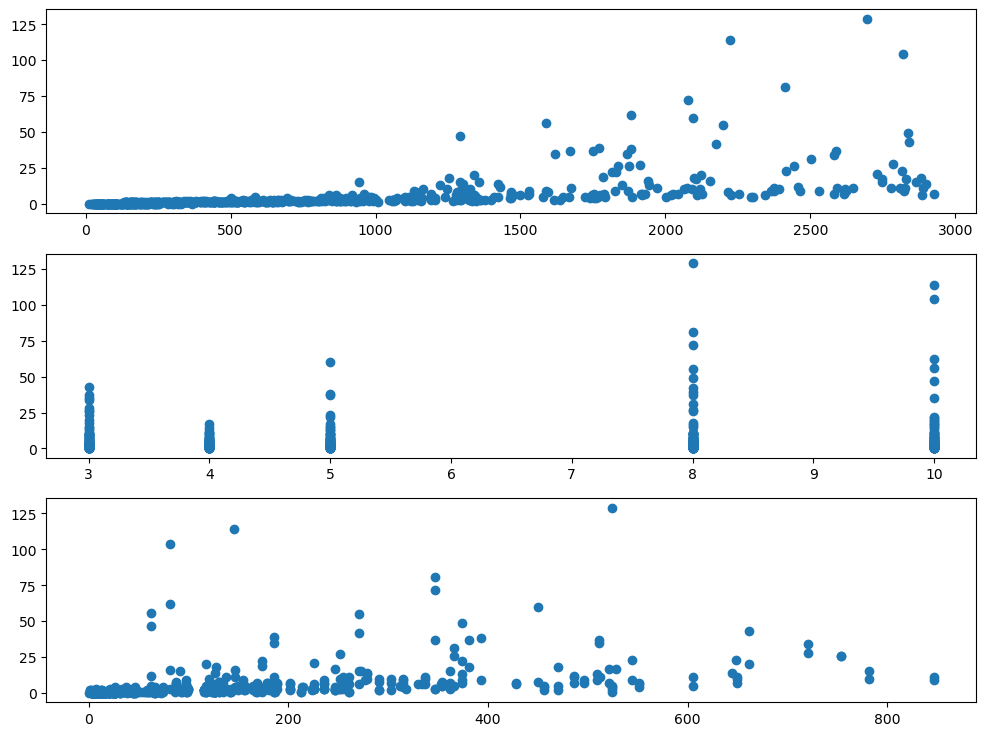

In [591]:
fix, ax = plt.subplots(3,figsize=(12,9))
ax[0].scatter(raster_frs, compute_times)
ax[1].scatter(pg_frs, compute_times)
ax[2].scatter(spikes_in_pgs, compute_times)
plt.show()

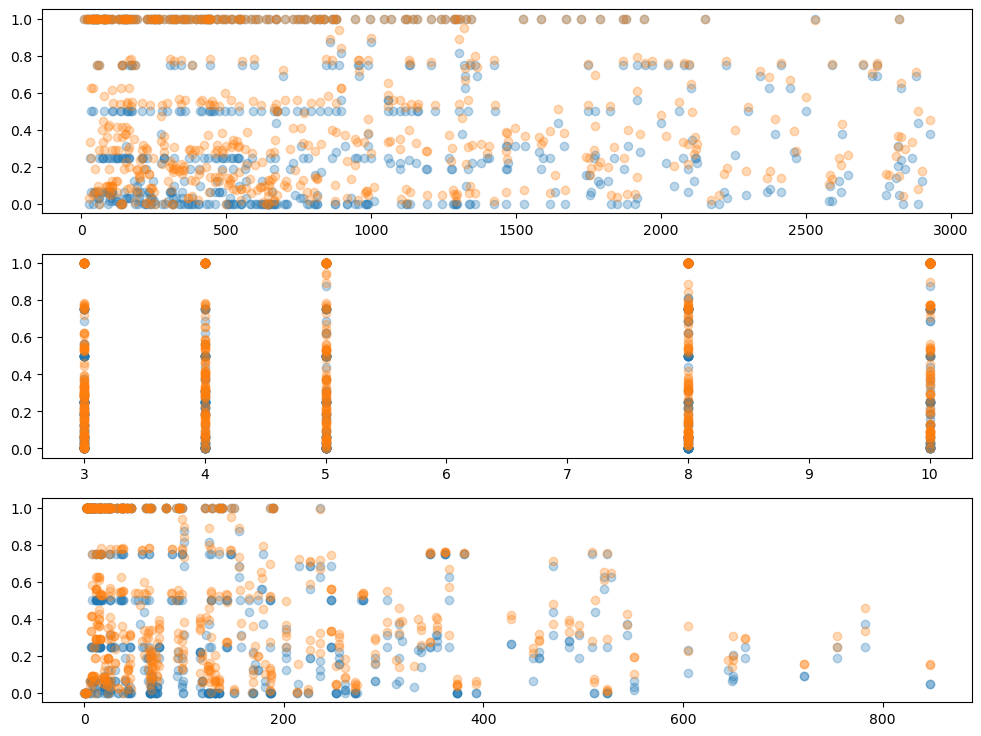

In [592]:
fix, ax = plt.subplots(3,figsize=(12,9))
ax[0].scatter(raster_frs, pct_good_SMs_detected,alpha=0.3)
ax[0].scatter(raster_frs, all_SM_qualities,alpha=0.3)
ax[1].scatter(pg_frs, pct_good_SMs_detected,alpha=0.3)
ax[1].scatter(pg_frs, all_SM_qualities,alpha=0.3)
ax[2].scatter(spikes_in_pgs, pct_good_SMs_detected,alpha=0.3)
ax[2].scatter(spikes_in_pgs, all_SM_qualities,alpha=0.3)
plt.show()

<Axes: >

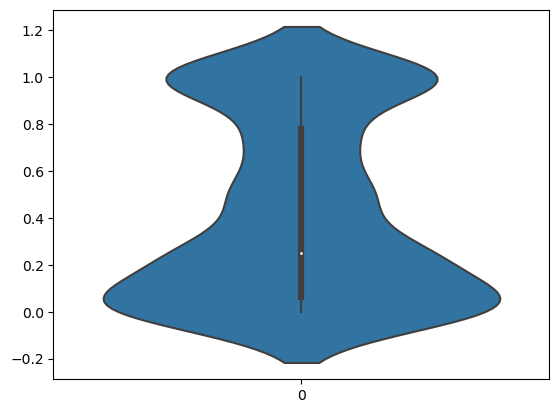

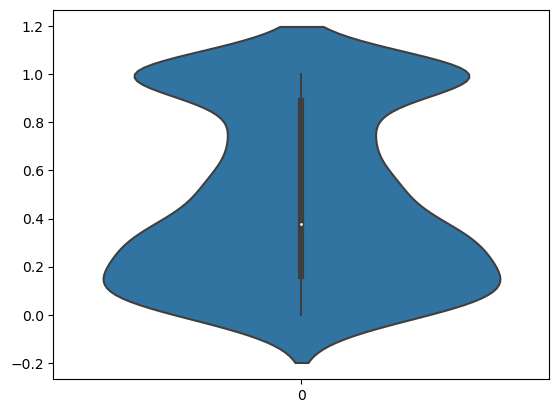

In [598]:
import seaborn as sns
sns.violinplot(df_filt['pct good SM detected'])
plt.figure()
sns.violinplot(df_filt['all SM quality'])


In [595]:
min(pct_good_SMs_detected), pct_good_SMs_detected

(0.0,
 [0.75,
  0.0,
  0.25,
  0.25,
  0.5,
  0.25,
  0.375,
  0.75,
  0.75,
  0.0,
  0.0,
  1.0,
  0.75,
  1.0,
  0.1875,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0625,
  0.0,
  0.75,
  1.0,
  0.0625,
  0.1875,
  1.0,
  0.0,
  0.75,
  0.0,
  1.0,
  0.1875,
  0.015625,
  0.3125,
  0.375,
  1.0,
  0.21875,
  0.265625,
  1.0,
  0.125,
  0.0,
  0.21875,
  1.0,
  1.0,
  0.5,
  0.0,
  0.6875,
  0.0,
  0.015625,
  0.25,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  0.5,
  0.6875,
  0.0625,
  0.5625,
  0.75,
  0.0,
  0.125,
  0.0625,
  1.0,
  0.0,
  0.25,
  0.25,
  0.0625,
  0.21875,
  0.25,
  1.0,
  0.1875,
  0.4375,
  1.0,
  0.25,
  1.0,
  0.1875,
  0.25,
  0.15625,
  0.25,
  1.0,
  0.5,
  0.15625,
  0.5,
  0.75,
  1.0,
  0.03125,
  0.0,
  1.0,
  0.0,
  1.0,
  0.5,
  0.8125,
  1.0,
  0.1875,
  0.6875,
  1.0,
  1.0,
  0.1875,
  0.03125,
  1.0,
  0.5,
  0.0,
  1.0,
  0.03125,
  0.3125,
  0.25,
  0.75,
  0.0,
  0.34375,
  0.015625,
  0.75,
  0.5,
  1.0,
  0.5,
  0.25,
  0.09375,
  0.5,
  0.25,
  0.75,
  0.1875,

In [582]:
df

,idc,seed,raster_fr,pg_fr,spikes_in_pg,M,N,D,T,nrn_fr,background_noise_fr,SM_acc,pct good SM detected,good SM quality,all SM quality,time
0,4887,0,"[9, 12, 14, 8, 13, 9, 13, 7, 6, 14, 11, 15, 14...",3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...",4,100,10,1000,10,10,"[0.1, 1.0, 1.0, 1.0]",0.75,1.0,0.775000,2
1,2623,0,"[1, 3, 6, 2, 4, 3, 5, 1, 2, 2, 3, 1, 2, 1, 2, ...",3,"[[1, 2, 2, 2, 3, 2, 5, 1, 0, 1, 2, 4, 4, 1, 1,...",1,100,150,1000,15,2,[0.004464285714285714],0.00,NaN,0.004464,1
2,3685,0,"[10, 6, 17, 8, 8, 1, 1, 7, 4, 8, 2, 3, 4, 14, ...",3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...",4,30,10,1000,10,5,"[0.0, 0.16666666666666666, 1.0, 0.0]",0.25,1.0,0.291667,0
3,3205,0,"[6, 1, 15, 3, 10, 1, 4, 3, 5, 1, 3, 20, 2, 1, ...",8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,...",4,30,10,1000,10,2,"[0.0, 0.16666666666666666, 1.0, 0.0]",0.25,1.0,0.291667,0
4,2566,0,"[2, 6, 12, 2, 7, 1, 3, 13, 4, 8, 2, 7, 1, 2, 4...",3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...",4,60,10,1000,15,2,"[0.1, 0.07142857142857142, 1.0, 1.0]",0.50,1.0,0.542857,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1047,0,"[20, 10, 36, 21, 5, 15, 15, 15, 21, 5, 15, 5, ...",10,"[[0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,...",4,100,10,1000,10,0,"[1.0, 1.0, 1.0, 1.0]",1.00,1.0,1.000000,1
996,1147,0,"[4, 17, 13, 18, 32, 9, 33, 6, 6, 13, 13, 9, 38...",10,"[[0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0,...",4,100,30,1000,15,0,"[1.0, 1.0, 1.0, 1.0]",1.00,1.0,1.000000,6
997,5720,0,"[13, 19, 18, 24, 33]",8,"[[0, 1, 1, 1, 2]]",1,5,70,1000,15,10,[1.0],1.00,1.0,1.000000,0
998,2100,0,"[2, 1, 1, 9, 2]",8,"[[0, 0, 0, 1, 0]]",1,5,30,1000,15,1,[],NaN,NaN,NaN,0


In [ ]:


fig, ax = plt.subplots(3,figsize=(12,9))
ax[0].hist(pct_good_SMs_detected)

In [ ]:
fix, ax = plt.subplots(3,figsize=(12,9))
ax[0].scatter(raster_frs, pct_good_SMs_detected,alpha=0.3)
ax[0].scatter(raster_frs, all_SM_qualities,alpha=0.3)
ax[1].scatter(pg_frs, pct_good_SMs_detected,alpha=0.3)
ax[1].scatter(pg_frs, all_SM_qualities,alpha=0.3)
ax[2].scatter(spikes_in_pgs, pct_good_SMs_detected,alpha=0.3)
ax[2].scatter(spikes_in_pgs, all_SM_qualities,alpha=0.3)
plt.show()

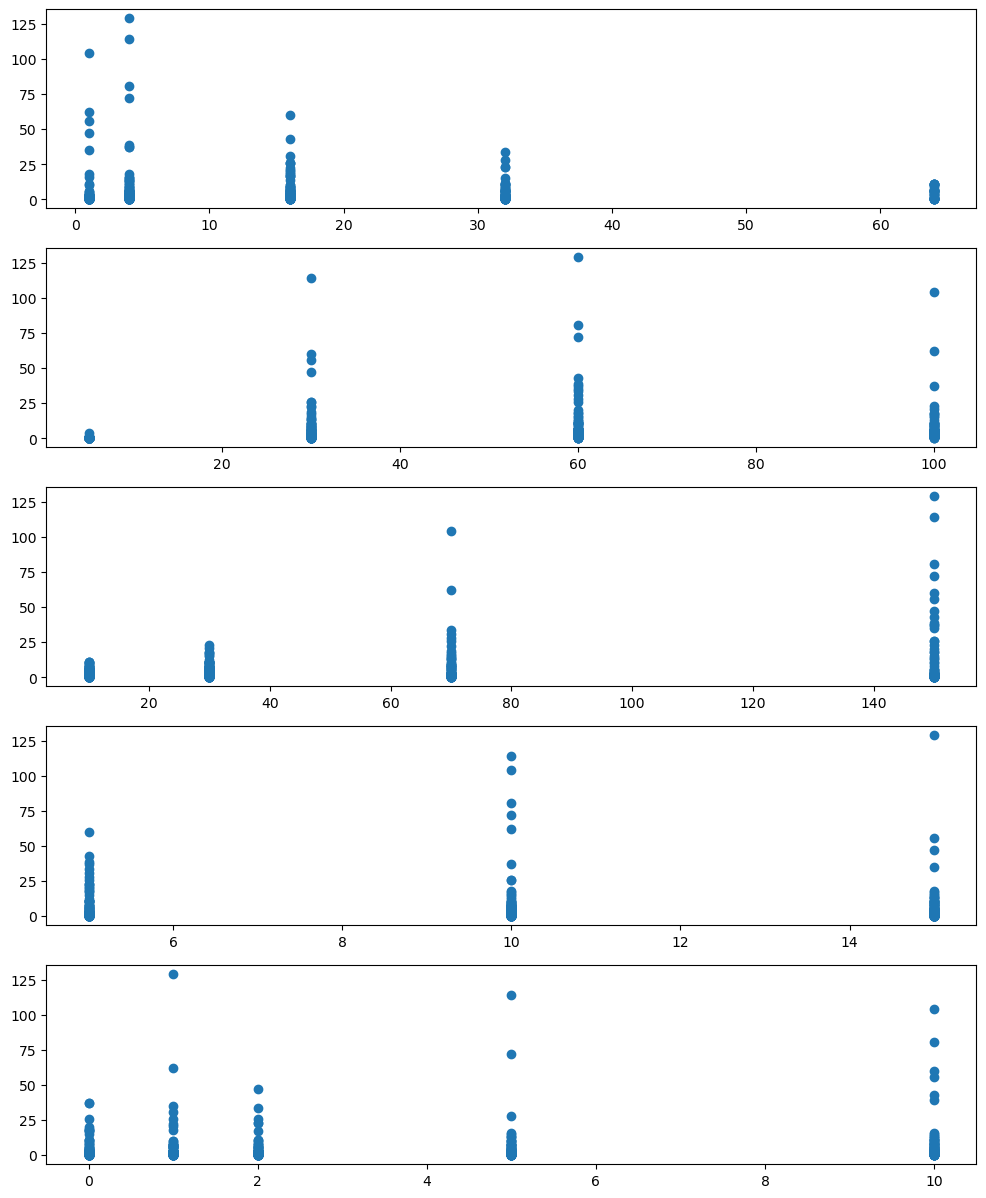

In [573]:
fix, ax = plt.subplots(5,figsize=(12,15))
ax[0].scatter(Ms, compute_times)
ax[1].scatter(Ns, compute_times)
ax[2].scatter(Ds, compute_times)
ax[3].scatter(nrn_frs, compute_times)
ax[4].scatter(background_noise_frs, compute_times)
plt.show()

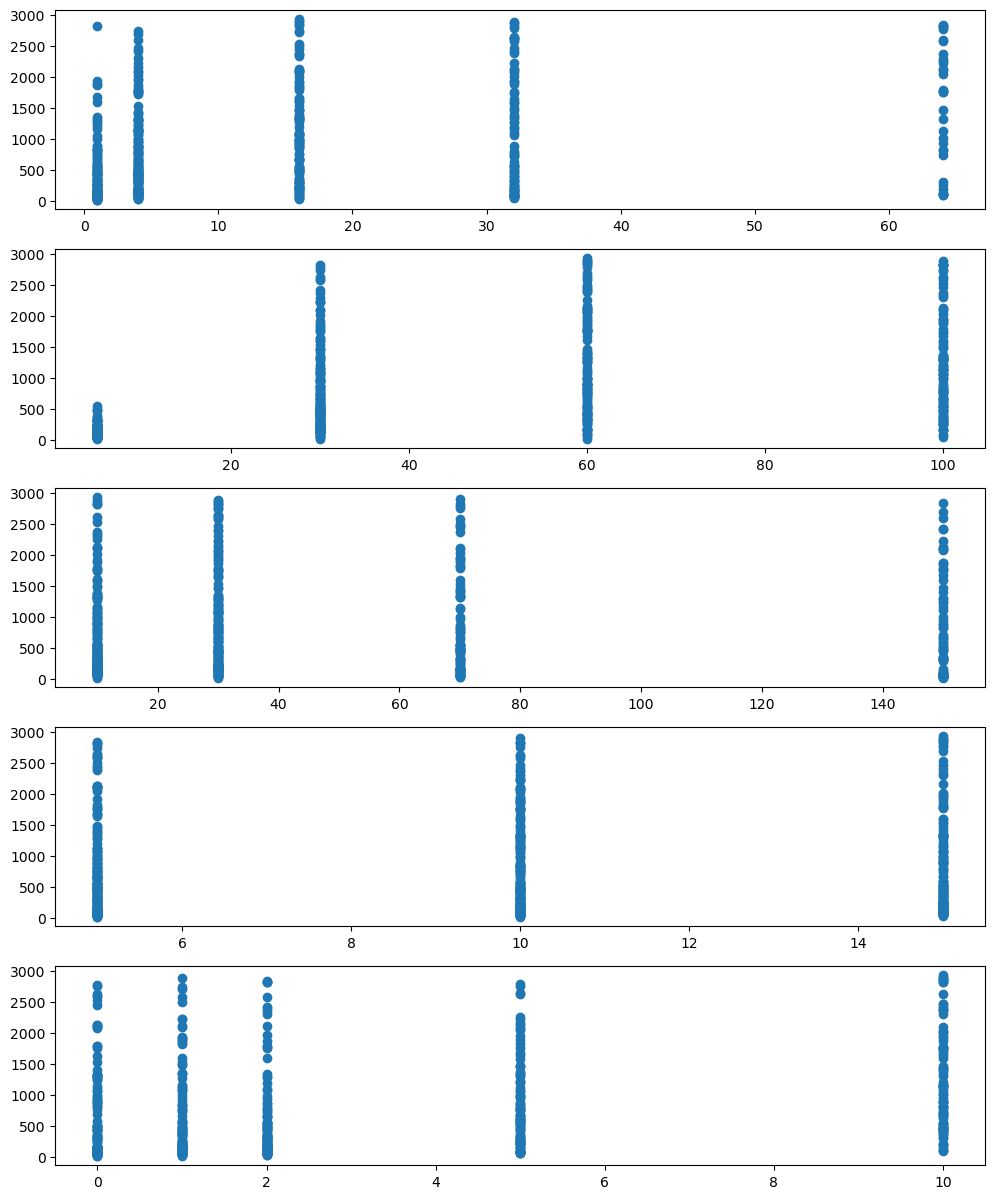

In [571]:
fix, ax = plt.subplots(5,figsize=(12,15))
ax[0].scatter(Ms, raster_frs)
ax[1].scatter(Ns, raster_frs)
ax[2].scatter(Ds, raster_frs)
ax[3].scatter(nrn_frs, raster_frs)
ax[4].scatter(background_noise_frs, raster_frs)
plt.show()